Выполнил: Кимельфельд Дмитрий. Варианты 1 и 6.


# Вариант 1. Дисперсия
Цель: Контроль дисперсии весов.

Разработайте архитектуру, которая будет за 5 слоев приводить тензор к размерности (1, 512, 1, 1).  

Условие: дисперсия весов третьего слоя должна быть в два раза больше, чем у второго и четвертого.  

Эксперимент: Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
class NN_Var(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (17, 17)) # (64, 16, 16)
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.conv4 = nn.Conv2d(128, 256, (3, 3))
        self.conv5 = nn.Conv2d(256, 512, (3, 3))


        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.pool = nn.MaxPool2d(2,2)

        self.act = nn.ReLU()
        
    def forward(self, x):
        # 1 ый слой
        X1 = self.conv1(x)
        X1 = self.act(X1)
  

        # 2 ой
        X2 = self.conv2(X1)
        X2 = self.act(X2)

        # 3 ий
        X3 = self.conv3(X2)
        X3 = self.act(X3)
        # 4 ый
        X4 = self.conv4(X3)
        X4 = self.act(X4)
        # 5 ый слой
        X5 = self.conv5(X4)
        X5 = self.act(X5)


        return self.GAP(X5)
   

                

In [3]:
m = NN_Var()
m(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 512, 1, 1])

In [4]:
import torch.nn.init as init
import numpy as np


def initialize_weights(model, Std = 0.1, multiplier=2):
    n_layer = 1
    for m in model.modules():
        if isinstance(m, nn.Conv2d) & (n_layer != 3) :
                init.normal_(m.weight, mean=.01, std=Std)
                n_layer += 1
        elif (n_layer == 3) & isinstance(m, nn.Conv2d):
                init.normal_(m.weight, mean=.01, std=Std * np.sqrt(multiplier))
                n_layer += 1




initialize_weights(m)

In [5]:
m.conv3.weight.data.var().item() / m.conv2.weight.data.var().item() , m.conv3.weight.data.var().item() / m.conv4.weight.data.var().item() 

(2.0014316525257074, 2.005449002882363)

In [6]:
m.fc4.weight.data.var().item() / m.fc4.weight.data.var().item() 

1.0

Таким образом, initialize_weights позволяет для новых инцилизированных моделей определять дисперсию весов, управляя разницей в дисперсиях между 3м полносвязнным слоем и остальными. var = $\sqrt{Std}$, поэтому существуют некоторый  multiplier, в корне, который дает нужное соотношение между дисперсией. 

- Как проверить влияние изменной дисперсии на 3 слоем?

    - Сравнить с нейросетью, в которой 3й слой будет с такой же дисперсией как остальные (multiplier)
    - Увеличить multiplier >> 2 - сделать эту разницу еще больше

In [7]:
m_, m_uni, m_more2 = NN_Var(), NN_Var(), NN_Var()

initialize_weights(m_)
initialize_weights(m_uni, multiplier=1)
initialize_weights(m_more2, multiplier=5)

models = [m_uni,  m_, m_more2]

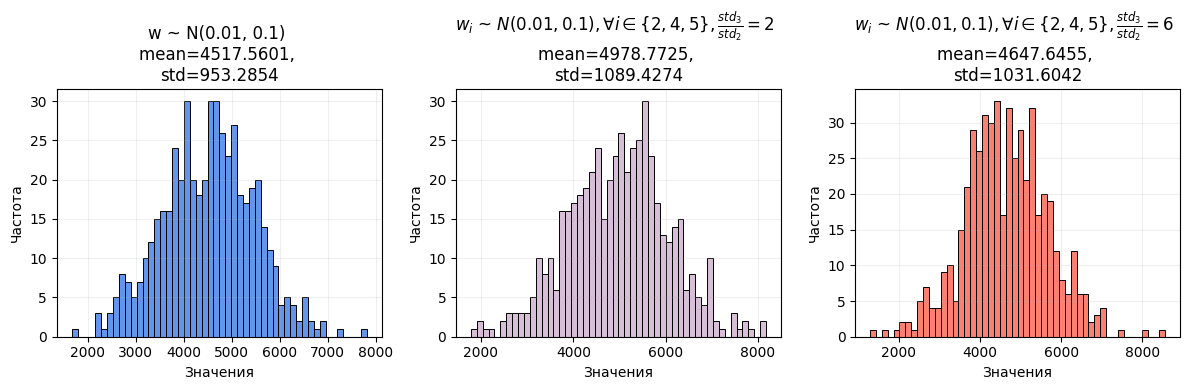

In [8]:

def plot_activation_distributions(models, model_names = ['w ~ N(0.01, 0.1)',
                                                        r'$w_i$ ~ $N(0.01, 0.1),  \forall i \in  \{2,4,5\}, \frac{std_3}{std_2}=2$ ',
                                                        r'$w_i$ ~ $N(0.01, 0.1),  \forall i \in  \{2,4,5\}, \frac{std_3}{std_2}=6$ '], colors = ['cornflowerblue', 'thistle','salmon']):
    """Распределения активаций"""
    x = torch.randn(1, 3, 32, 32)
    outputs = []
    with torch.no_grad():
      for model in models:
        outputs.append(model(x))

    fig, axs = plt.subplots(1, len(models), figsize=(12, 4))
    for i, output in enumerate(outputs):
        arr = output.numpy().flatten()
        axs[i].hist(arr, bins=50, color = colors[i], edgecolor="black", linewidth = 0.7)
        axs[i].set_title(f"{model_names[i]} \nmean={arr.mean():.4f}, \nstd={arr.std():.4f}")
        axs[i].set_xlabel("Значения")
        axs[i].set_ylabel("Частота")
        axs[i].grid(True, alpha = 0.2)


    plt.tight_layout()
    plt.show()

plot_activation_distributions(models)

Таким образом, с увеличением дисперсии на 3 слое - увеличивается среднее значение активаций и дисперсия.

# Вариант 6. Использование разных типов пулинга

Цель: Сравнение MaxPool и Global Average Pooling.

Спроектируйте сеть для входа (3, 64, 64) и выхода (32, 8, 8).
- Условие: В сети обязательно должны быть и MaxPool2d, и AdaptiveAvgPool2d.

- Эксперимент: Сравните выходы после MaxPool и GAP на одном и том же случайном тензоре
    - визуализируйте карты признаков;

    - среднее значение активаций.  



# Теоретическая справка  

Пуллинг - операция **агрегации** соседних значений последовательности или активаций свертки.  (AVG / MAX)

Предзначение  пуллинга, как операции, он позволяет уменьшить в объеме число информации в карте признаков, минимизировав потери информации об объекте.

MaxPool - функция пуллинга, возврающая максимальных элемент из свертки (заданного окна).

Интуиция:
- Максимизирующий пулинг извлекает наличие интересуемого признака где-либо в агрегируемой области.
- Усредняющий пулинг извлекает среднюю представленность интересуемого признака в агрегируемой области.

Global average pooling (GAP) - принцип, по которому в каждом канале нужно брать среднее вдоль пространственных осей нашего последнего тензора и усреднять их активации, после чего каждому каналу сопоставить максимальный усредненнее значение активаций (сверток-усредняющих).

In [9]:
import torch
from torch import nn

In [10]:
import torch.nn.functional as F

class CNN_MAX_POOL(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(33, 33), padding=0) # (32, 32, 32)
        self.avg = nn.AdaptiveAvgPool2d((16, 16)) # (32, 16, 16)
        self.max_pool = nn.MaxPool2d((2, 2)) # (32, 8, 8)
        # For GAP
        self.gap = nn.AdaptiveAvgPool2d(8) # (32, 1, 1)
        # For activation
        self.activation = nn.ReLU()

    def forward(self, x):
        # 1 L Out - > (32, 32, 32)
        x = self.activation(self.conv1(x))
        # 2 L Out -> (32, 8, 8) 
        x = self.activation(self.avg(x))
        x_gap = self.gap(x)
        x_max_p = self.max_pool(x)
        return x_gap, x_max_p

In [11]:
torch.manual_seed(5)
T = torch.randn(3, 64, 64)
model = CNN_MAX_POOL()
X, X_PoolMax = model(T,)

In [12]:
X.shape, X_PoolMax.shape

(torch.Size([32, 8, 8]), torch.Size([32, 8, 8]))

# Сравнения карт признаков и активаций

- Визуализируем карту признаков для метода GAP и модуль разницы карт признаков $|X_{GAP} - X_{maxPool}|$

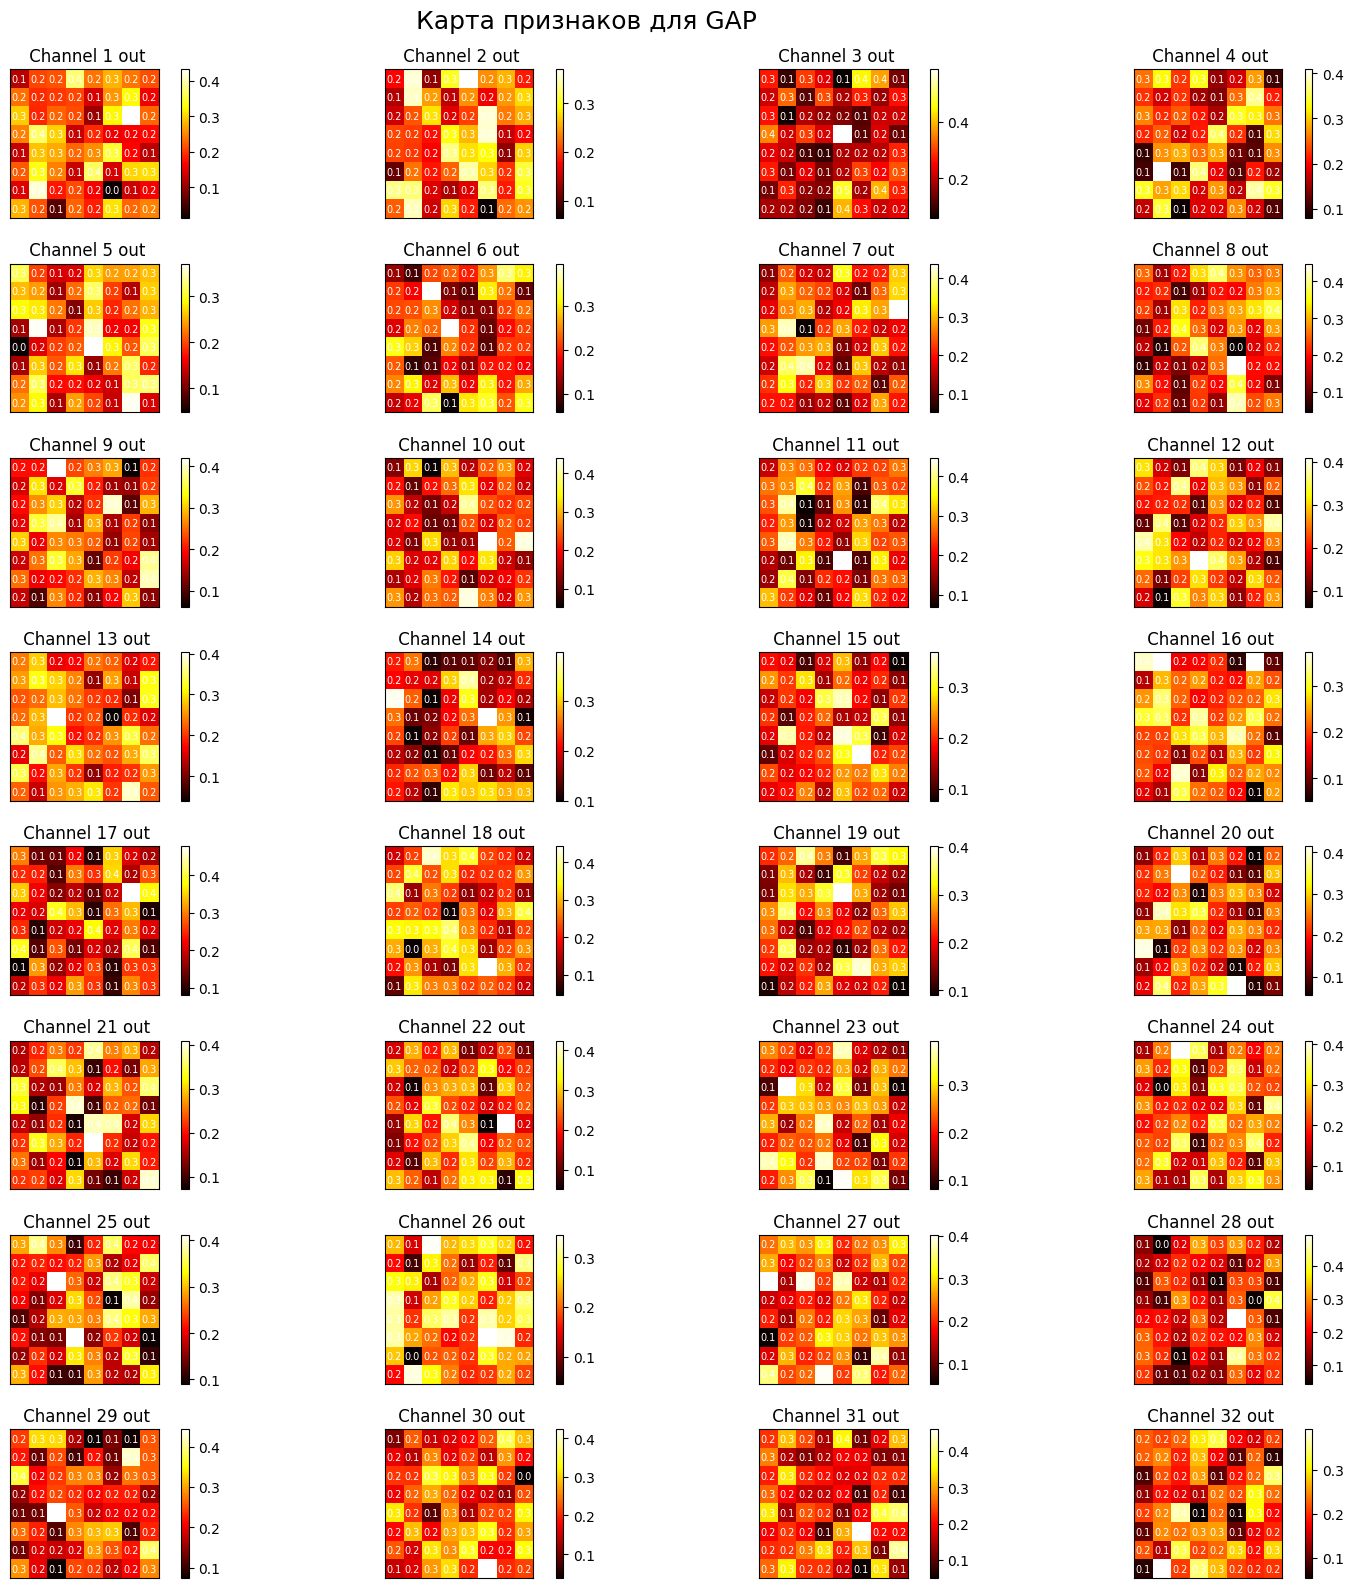

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_map(x, ax, title,):

    # Создаем heatmap
    im = ax.imshow(x, cmap='hot', interpolation='nearest')
    
    # Добавляем значения в ячейки
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            ax.text(j, i, f'{x[i, j]:.1f}', 
                    ha='center', va='center', 
                    color='white', fontsize=7)
    
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Добавляем колорбар
    plt.colorbar(im, ax=ax)
    
    return im

_ , axes = plt.subplots(ncols= 4, nrows=8, figsize=(16,16))
axes = axes.flatten()


k = 1
for ax, x in zip(axes, X):
    x = x.detach().numpy()
    plot_feature_map(x, ax, f' Channel {k} out',)
    k += 1
plt.suptitle('Карта признаков для GAP', fontsize=18, y=0.99)
plt.tight_layout()


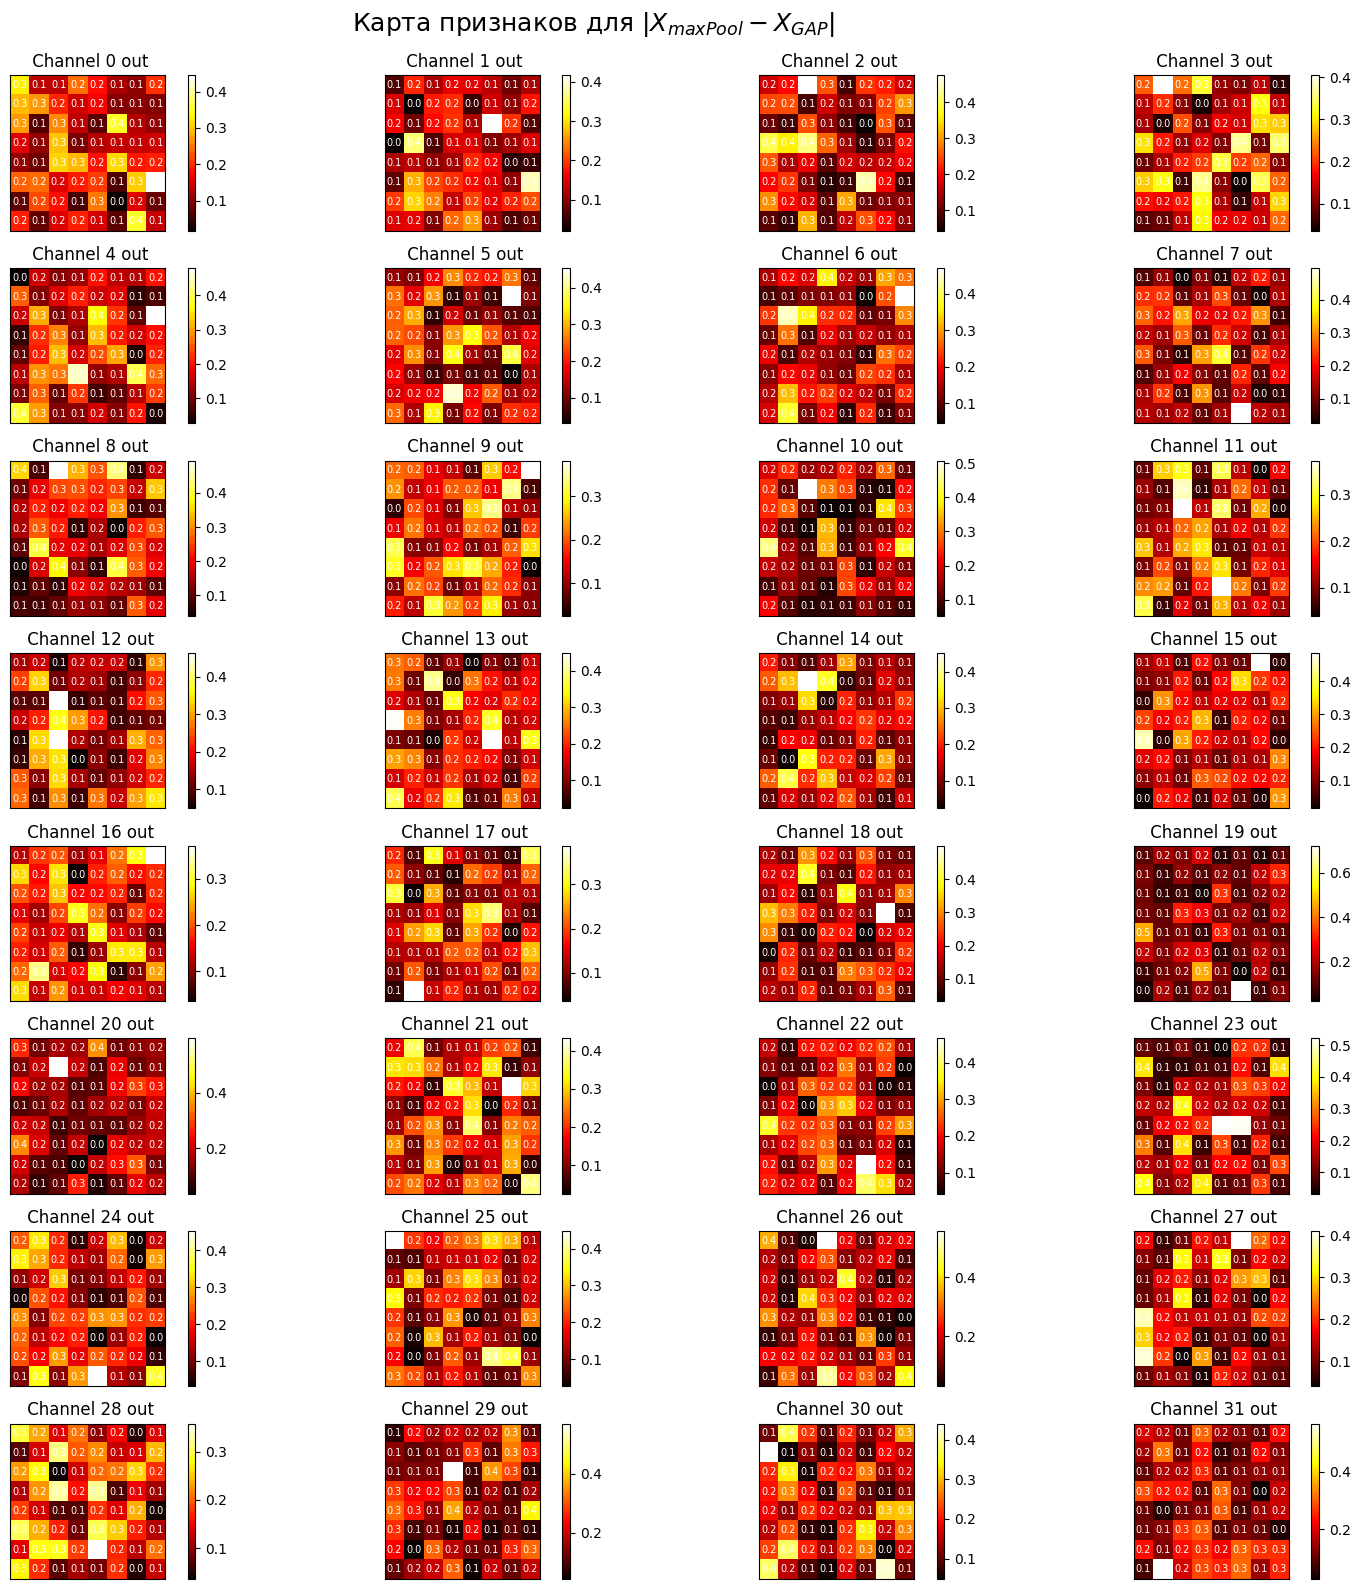

In [14]:
X_dif = np.abs(X.detach().numpy()-X_PoolMax.detach().numpy())
_ , axes = plt.subplots(ncols= 4, nrows=8, figsize=(16,16))
axes = axes.flatten()
k=0

for ax, x in zip(axes, X_dif):
    plot_feature_map(x, ax, f' Channel {k} out',)
    k += 1
plt.suptitle('Карта признаков для $|X_{maxPool} - X_{GAP}|$', fontsize=18, y=0.99)
plt.tight_layout()

In [15]:
m = np.mean(X_dif, axis=1).mean(axis=1)
print('Средний модуль разности в картах - %.3f' % m.mean())


Средний модуль разности в картах - 0.178


Для того, чтобы сделать вывод о том, как карты влияют на активации, необходимо добавить функции активации и усреднения по картам признаков. 


In [16]:
Activation = nn.ReLU()
Average = nn.AdaptiveAvgPool2d(1)
Mean_act = nn.Sequential(Activation, Average)

print( 'Средняя активация после Gap %.2f и после MaxPool %.2f'  % ( Mean_act(X).mean(), Mean_act(X_PoolMax).mean()))

Средняя активация после Gap 0.22 и после MaxPool 0.40


Text(0.5, 1.0, 'Распределение разниц усреденненых активаций между 2 методами')

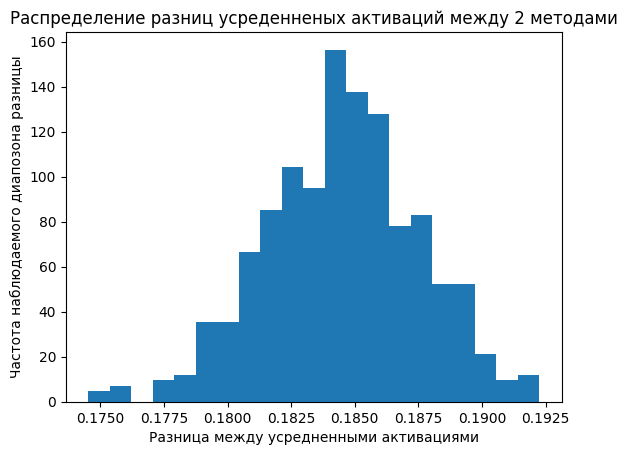

In [17]:
res=[]
for _ in range(500):
    T = torch.randn(3, 64, 64)
    X, X_GAP = model(T)
    est = (Mean_act(X_GAP).mean() - Mean_act(X).mean()).detach().numpy()
    res.append(est)
plt.hist(np.asarray(res),bins=21,density=True)
plt.xlabel('Разница между усредненными активациями')
plt.ylabel('Частота наблюдаемого диапозона разницы')
plt.title('Распределение разниц усреденненых активаций между 2 методами')


Наблюдения:  
- Разница между активациями распределена ~ нормально, что обусловлено случайной генерацией тензоров, подаваемых на вход
- Средняя разница усредененных активаций распределена возле среденего ~ 0.185 => методом GAP активицаии в среднем больше всегда.  